In [1]:
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets

import args
import utils
from networks import LossNetwork, StyleBankNet

device = args.device

In [2]:
"""
Load Dataset
"""
content_dataset = datasets.ImageFolder(root=args.CONTENT_IMG_DIR, transform=utils.content_img_transform)
content_dataloader = torch.utils.data.DataLoader(content_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

style_dataset = datasets.ImageFolder(root=args.NEW_STYLE_IMG_DIR, transform=utils.style_img_transform)
style_dataset = torch.cat([img[0].unsqueeze(0) for img in style_dataset], dim=0)
style_dataset = style_dataset.to(device)

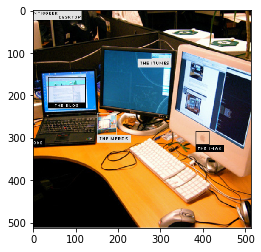

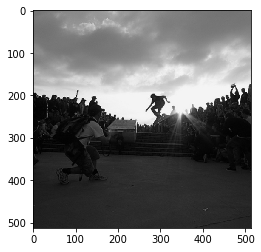

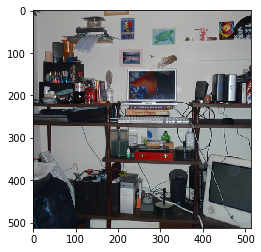

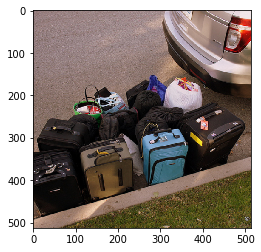

In [3]:
"""
Display content images
"""
for imgs, _ in content_dataloader:
    for i in range(args.batch_size):
        utils.showimg(imgs[i])
    break

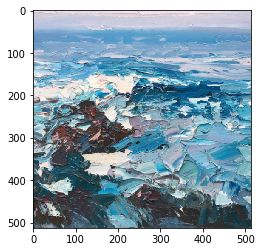

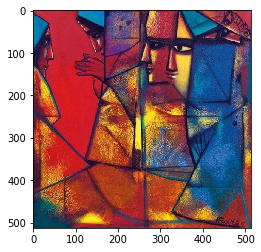

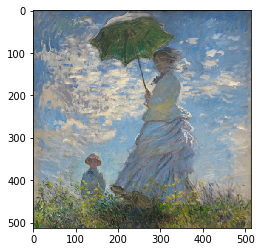

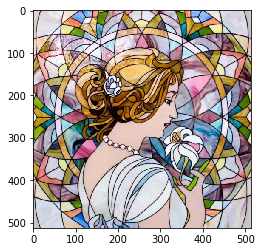

In [4]:
"""
Display style images
"""
for img in style_dataset:
    utils.showimg(img)

In [5]:
"""
Define Model and Loss Network (vgg16)
"""
model = StyleBankNet(len(style_dataset)).to(device)

if os.path.exists(args.ENCODER_WEIGHT_PATH):
    model.encoder_net.load_state_dict(torch.load(args.ENCODER_WEIGHT_PATH))
else:
    raise Exception('cannot find encoder weights')

if os.path.exists(args.DECODER_WEIGHT_PATH):
    model.decoder_net.load_state_dict(torch.load(args.DECODER_WEIGHT_PATH))
else:
    raise Exception('cannot find encoder weights')

if not os.path.exists(args.NEW_BANK_WEIGHT_DIR):
    os.mkdir(args.NEW_BANK_WEIGHT_DIR)

model.encoder_net.eval()
model.decoder_net.eval()
model.style_bank.train()
# only update the bank
optimizer = optim.Adam(model.style_bank.parameters(), lr=args.lr)
loss_network = LossNetwork().to(device)

In [6]:
"""
Training
"""

# [0, 1, 2, ..., N]
style_id = list(range(len(style_dataset)))
style_id_idx = 0
style_id_seg = []
for i in range(0, len(style_dataset), args.batch_size):
    style_id_seg.append(style_id[i:i+args.batch_size])
    
s_sum = 0 # sum of style loss
c_sum = 0 # sum of content loss
l_sum = 0 # sum of style+content loss
tv_sum = 0 # sum of tv loss

global_step = 0
LOG_ITER = int(args.LOG_ITER)

while global_step <= args.MAX_ITERATION:
    for i, data in enumerate(content_dataloader):
        global_step += 1
        data = data[0].to(device)
        batch_size = data.shape[0]
        
        style_id_idx += 1
        sid = utils.get_sid_batch(style_id_seg[style_id_idx % len(style_id_seg)], batch_size)

        optimizer.zero_grad()
        output_image = model(data, sid)
        content_score, style_score = loss_network(output_image, data, style_dataset[sid])
        content_loss = args.CONTENT_WEIGHT * content_score
        style_loss = args.STYLE_WEIGHT * style_score

        diff_i = torch.sum(torch.abs(output_image[:, :, :, 1:] - output_image[:, :, :, :-1]))
        diff_j = torch.sum(torch.abs(output_image[:, :, 1:, :] - output_image[:, :, :-1, :]))
        tv_loss = args.REG_WEIGHT*(diff_i + diff_j)

        total_loss = content_loss + style_loss + tv_loss
        total_loss.backward()
        optimizer.step()

        l_sum += total_loss.item()
        s_sum += style_loss.item()
        c_sum += content_loss.item()
        tv_sum += tv_loss.item()
            
        if global_step % 100 == 0:
            print('.', end='')
            
        if global_step % LOG_ITER == 0:
            print("gs: {} {} {:.6f} {:.6f} {:.6f} {:.6f}".format(global_step / args.K, time.strftime("%H:%M:%S"), l_sum / LOG_ITER, c_sum / LOG_ITER, s_sum / LOG_ITER, tv_sum / LOG_ITER))
            s_sum = 0
            c_sum = 0
            l_sum = 0
            tv_sum = 0

            # save the bank
            for i in range(len(style_dataset)):
                torch.save(model.style_bank[i].state_dict(), args.NEW_BANK_WEIGHT_PATH.format(i))
            
        if global_step % args.ADJUST_LR_ITER == 0:
            lr_step = global_step / args.ADJUST_LR_ITER
            new_lr = utils.adjust_learning_rate(optimizer, lr_step)
            
            print("learning rate decay:", new_lr)

..........gs: 1.0 18:50:58 244.337069 121.407264 120.287716 2.642090
..........gs: 2.0 18:59:34 187.660574 115.483073 69.528034 2.649467
..........gs: 3.0 19:08:10 182.361390 114.182878 65.534469 2.644043
..........gs: 4.0 19:16:46 174.226185 112.344035 59.240486 2.641664
..........gs: 5.0 19:25:23 172.867749 112.583124 57.643756 2.640869
..........gs: 6.0 19:34:01 171.209974 111.720404 56.851639 2.637932
..........gs: 7.0 19:42:39 168.207812 110.913226 54.656216 2.638371
..........gs: 8.0 19:51:17 165.711007 109.992045 53.081276 2.637686
..........gs: 9.0 19:59:55 164.463251 109.770641 52.057897 2.634714
..........gs: 10.0 20:08:33 164.064768 109.304422 52.124676 2.635669
learning rate decay: 0.0008
..........gs: 11.0 20:17:11 161.989031 109.562971 49.791825 2.634235
..........gs: 12.0 20:25:50 160.333377 108.380903 49.317679 2.634795
..........gs: 13.0 20:34:27 159.414178 108.682860 48.097152 2.634166
..........gs: 14.0 20:43:05 158.389389 108.165485 47.591268 2.632636
.

Process Process-8:
Process Process-5:
Process Process-6:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process

KeyboardInterrupt: 

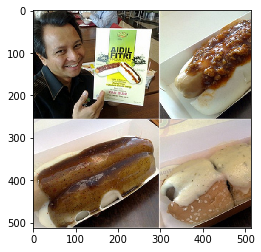

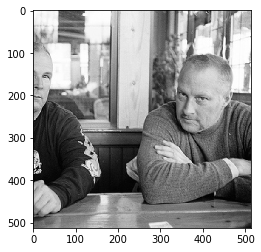

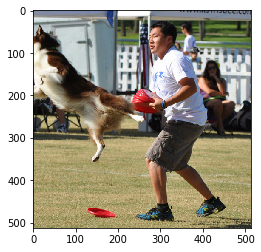

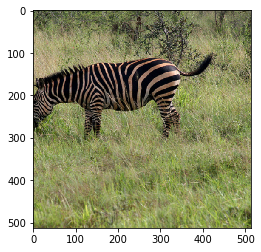

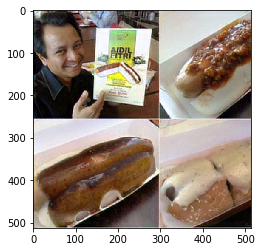

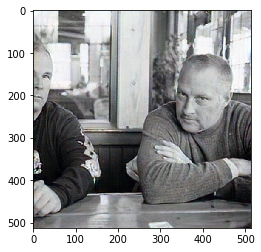

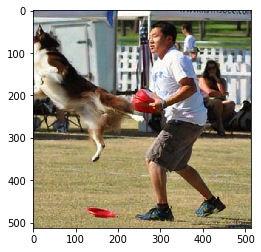

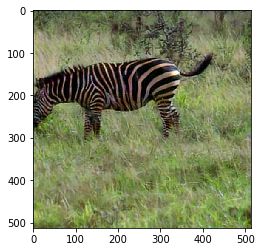

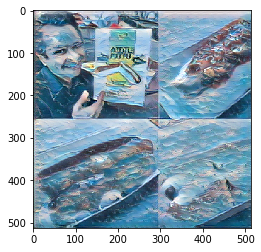

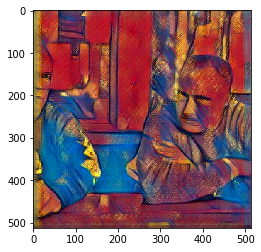

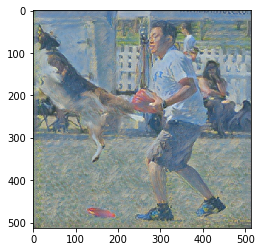

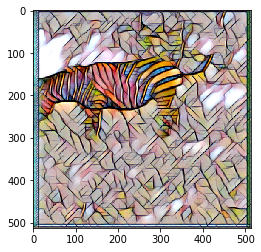

In [9]:
"""
Testing
"""
for i, data in enumerate(content_dataloader, 0):
    data = data[0].to(device)
    batch_size = data.shape[0]
#     data = data[0].repeat(batch_size, 1, 1, 1)
    for j in range(batch_size):
        utils.showimg(data[j].cpu())
    
    output_image = model(data)
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    output_image = model(data, utils.get_sid_batch(style_id_seg[0], batch_size))
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    break